<h2><center>CM3070 Computer Science Final Project</center></h2>
<h2><center>Ng Ka Hou (190387028)</center></h2>

In [1]:
# libraries for linear regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import glob
import os

# libraries for tensorflow
import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras import models, layers
from sklearn.model_selection import KFold


# libraries for gridsearch
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

import random

C:\Users\ngkah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preparation ##

### Load Data ###

#### Exchange Rate Dataset

In [2]:
# read the dataset of exchange rate
df_exh_rate=pd.read_csv('./data/FRB_H10.csv')

In [3]:
df_exh_rate.head()

,Series Description,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)"
0,Unit:,Currency:_Per_GBP
1,Multiplier:,1
2,Currency:,USD
3,Unique Identifier:,H10/H10/RXI$US_N.B.UK
4,Time Period,RXI$US_N.B.UK


In [4]:
# remove the first 4 rows
df_exh_rate = df_exh_rate.iloc[5:]

In [5]:
df_exh_rate.head()

,Series Description,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)"
5,1971-01-04,2.3938
6,1971-01-05,2.3949
7,1971-01-06,2.3967
8,1971-01-07,2.3963
9,1971-01-08,2.3972


In [6]:
# change column name
df_exh_rate.columns = ['date', 'gbp_per_usd']

In [7]:
# reindex the dataset
df_exh_rate.reset_index(drop=True, inplace=True)

In [8]:
# change the data type of the date column
df_exh_rate['date'] = pd.to_datetime(df_exh_rate['date'])

In [9]:
# output of the exchange rate data
df_exh_rate.head()

,date,gbp_per_usd
0,1971-01-04,2.3938
1,1971-01-05,2.3949
2,1971-01-06,2.3967
3,1971-01-07,2.3963
4,1971-01-08,2.3972


#### USD Interest Rate Dataset

In [10]:
# read the dataset of usd yield curve
df_usd_int=pd.read_csv('./data/yield-curve-rates-1990-2023.csv')

In [11]:
df_usd_int.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/29/23,5.60,5.59,5.40,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03
1,12/28/23,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2,12/27/23,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
3,12/26/23,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
4,12/22/23,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05


In [12]:
# keep only the Date and 6Mo columns
df_usd_int=df_usd_int[['Date', '6 Mo']]

In [13]:
# keep only the date and the 6-Month USD interst rate
df_usd_int.head()

,Date,6 Mo
0,12/29/23,5.26
1,12/28/23,5.28
2,12/27/23,5.26
3,12/26/23,5.28
4,12/22/23,5.31


In [14]:
# rename columns
df_usd_int.rename(columns={'Date': 'date', '6 Mo': '6m_usd_int_rate'}, inplace=True)

In [15]:
df_usd_int.head()

,date,6m_usd_int_rate
0,12/29/23,5.26
1,12/28/23,5.28
2,12/27/23,5.26
3,12/26/23,5.28
4,12/22/23,5.31


#### GBP Interset Rate Dataset

This dataset is not in csv format, instead it is a brunch of xlsx excel file. Therefore a loop is needed to import the data.

In [16]:
# file path
folder_path='./data/gbp_yield_data'
files = os.path.join(folder_path, '*.xlsx')

In [17]:
# array to store the gbp spot yield curve from each excel file
df_gbp_int_arr=[]

In [18]:
# loop to get the dataset
for file in glob.glob(files):
    # get the data from the sheet with name '4. nominal spot curve'
    # and skip the first 3 rows
    df_temp=pd.read_excel(file, sheet_name='4. nominal spot curve', skiprows=3)
    # drop the first row
    df_temp=df_temp.drop(index=0)
    # append data to the array
    df_gbp_int_arr.append(df_temp)

In [19]:
# convert the array of gbp yield curve to dataframe
df_gbp_int = pd.concat(df_gbp_int_arr, ignore_index=True)

In [20]:
df_gbp_int.tail()

,years:,0.5,1,1.5,2,2.5,3,3.5,4,4.5,...,35.5,36,36.5,37,37.5,38,38.5,39,39.5,40
11845,2024-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11846,2024-05-28,4.745348,4.746281,4.633256,4.509136,4.401753,4.313099,4.241701,4.185945,4.144182,...,4.625468,4.614194,4.602530,4.590477,4.578035,4.565204,4.551985,4.538377,4.524380,4.509996
11847,2024-05-29,4.772091,4.786440,4.688452,4.578423,4.482607,4.402885,4.338254,4.287633,4.249800,...,4.743537,4.732074,4.720217,4.707968,4.695329,4.682301,4.668883,4.655077,4.640883,4.626303
11848,2024-05-30,4.736628,4.725816,4.629424,4.524510,4.433929,4.358911,4.298358,4.251228,4.216365,...,4.719720,4.708189,4.696267,4.683957,4.671261,4.658180,4.644715,4.630868,4.616638,4.602029
11849,2024-05-31,4.720087,4.695043,4.584558,4.472636,4.380579,4.306682,4.248079,4.202832,4.169367,...,4.639544,4.627790,4.615654,4.603140,4.590250,4.576986,4.563351,4.549346,4.534971,4.520230


In [21]:
# keep only the date and the 6-Month gbp yield curve data
df_gbp_int=df_gbp_int[['years:',0.5]]

In [22]:
# rename the columns
df_gbp_int.rename(columns={'years:': 'date', 0.5: '6m_gbp_int_rate'}, inplace=True)

In [23]:
df_gbp_int.tail()

,date,6m_gbp_int_rate
11845,2024-05-27,NaN
11846,2024-05-28,4.745348
11847,2024-05-29,4.772091
11848,2024-05-30,4.736628
11849,2024-05-31,4.720087


In [24]:
# change all date value to datatime
df_exh_rate['date'] = pd.to_datetime(df_exh_rate['date'])
df_usd_int['date'] = pd.to_datetime(df_usd_int['date'], format='%m/%d/%y')
df_gbp_int['date'] = pd.to_datetime(df_gbp_int['date'])

In [25]:
df_exh_rate.head()

,date,gbp_per_usd
0,1971-01-04,2.3938
1,1971-01-05,2.3949
2,1971-01-06,2.3967
3,1971-01-07,2.3963
4,1971-01-08,2.3972


In [26]:
df_usd_int.head()

,date,6m_usd_int_rate
0,2023-12-29,5.26
1,2023-12-28,5.28
2,2023-12-27,5.26
3,2023-12-26,5.28
4,2023-12-22,5.31


In [27]:
df_gbp_int.head()

,date,6m_gbp_int_rate
0,1979-01-01,NaN
1,1979-01-02,NaN
2,1979-01-03,NaN
3,1979-01-04,NaN
4,1979-01-05,NaN


In [28]:
# merge the USD interest rate 
# to the exchange rate dataset on the date column
df=df_exh_rate.merge(df_usd_int, on='date', how='left')

In [29]:
# merge the GBP interest rate 
# to the exchange rate dataset on the date column
df=df.merge(df_gbp_int, on='date', how='left')

In [30]:
# add a new date column that the values 
# is shiftted 6 months from the original date column
df['date_plus_6m']=df['date'] + pd.DateOffset(months=6)

In [31]:
# covert the new date column as datetime
df['date_plus_6m'] = pd.to_datetime(df['date_plus_6m'])

In [32]:
df.head()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,date_plus_6m
0,1971-01-04,2.3938,NaN,NaN,1971-07-04
1,1971-01-05,2.3949,NaN,NaN,1971-07-05
2,1971-01-06,2.3967,NaN,NaN,1971-07-06
3,1971-01-07,2.3963,NaN,NaN,1971-07-07
4,1971-01-08,2.3972,NaN,NaN,1971-07-08


In [33]:
df.tail()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,date_plus_6m
13930,2024-05-27,ND,NaN,NaN,2024-11-27
13931,2024-05-28,1.2786,NaN,4.745348,2024-11-28
13932,2024-05-29,1.2714,NaN,4.772091,2024-11-29
13933,2024-05-30,1.2739,NaN,4.736628,2024-11-30
13934,2024-05-31,1.2738,NaN,4.720087,2024-11-30


In [34]:
# merge the exchange rate dataset to the merged dataset on the shiftted date column
df=df.merge(df_exh_rate, left_on='date_plus_6m', right_on='date', how='left')

In [35]:
df.head()

,date_x,gbp_per_usd_x,6m_usd_int_rate,6m_gbp_int_rate,date_plus_6m,date_y,gbp_per_usd_y
0,1971-01-04,2.3938,NaN,NaN,1971-07-04,NaT,NaN
1,1971-01-05,2.3949,NaN,NaN,1971-07-05,1971-07-05,ND
2,1971-01-06,2.3967,NaN,NaN,1971-07-06,1971-07-06,2.4181
3,1971-01-07,2.3963,NaN,NaN,1971-07-07,1971-07-07,2.4187
4,1971-01-08,2.3972,NaN,NaN,1971-07-08,1971-07-08,2.4185


In [36]:
# drop the helper columns for mapping sake only
df.drop(columns=['date_plus_6m', 'date_y'],inplace=True)

In [37]:
df.head()

,date_x,gbp_per_usd_x,6m_usd_int_rate,6m_gbp_int_rate,gbp_per_usd_y
0,1971-01-04,2.3938,NaN,NaN,NaN
1,1971-01-05,2.3949,NaN,NaN,ND
2,1971-01-06,2.3967,NaN,NaN,2.4181
3,1971-01-07,2.3963,NaN,NaN,2.4187
4,1971-01-08,2.3972,NaN,NaN,2.4185


In [38]:
# rename columns
df.rename(columns={'date_x': 'date', 'gbp_per_usd_x': 'gbp_per_usd', 'gbp_per_usd_y': 'gbp_per_usd_plus_6m'}, inplace=True)

In [39]:
df.head()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,gbp_per_usd_plus_6m
0,1971-01-04,2.3938,NaN,NaN,NaN
1,1971-01-05,2.3949,NaN,NaN,ND
2,1971-01-06,2.3967,NaN,NaN,2.4181
3,1971-01-07,2.3963,NaN,NaN,2.4187
4,1971-01-08,2.3972,NaN,NaN,2.4185


In [40]:
# convert all non-numeric data to NaN
for col in df.columns:
    if col != 'date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [41]:
df.head()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,gbp_per_usd_plus_6m
0,1971-01-04,2.3938,NaN,NaN,NaN
1,1971-01-05,2.3949,NaN,NaN,NaN
2,1971-01-06,2.3967,NaN,NaN,2.4181
3,1971-01-07,2.3963,NaN,NaN,2.4187
4,1971-01-08,2.3972,NaN,NaN,2.4185


In [42]:
df.tail()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,gbp_per_usd_plus_6m
13930,2024-05-27,NaN,NaN,NaN,NaN
13931,2024-05-28,1.2786,NaN,4.745348,NaN
13932,2024-05-29,1.2714,NaN,4.772091,NaN
13933,2024-05-30,1.2739,NaN,4.736628,NaN
13934,2024-05-31,1.2738,NaN,4.720087,NaN


In [43]:
# drop all rows with any NaN values
df=df.dropna()

In [44]:
# reset index
df.reset_index(drop=True, inplace=True)

In [45]:
df.head()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,gbp_per_usd_plus_6m
0,1990-07-11,1.7980,8.15,13.924546,1.9070
1,1990-07-16,1.8040,7.91,13.757289,1.9047
2,1990-07-17,1.8112,7.91,13.700931,1.9228
3,1990-07-18,1.8205,7.88,13.768089,1.9416
4,1990-07-23,1.8205,7.78,13.729768,1.9550


In [46]:
df.tail()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,gbp_per_usd_plus_6m
5120,2023-11-22,1.2468,5.42,4.977611,1.2739
5121,2023-11-24,1.2601,5.45,4.998473,1.2746
5122,2023-11-28,1.2713,5.42,4.928856,1.2786
5123,2023-11-29,1.2690,5.38,4.927527,1.2714
5124,2023-11-30,1.2640,5.38,4.962727,1.2739


In [47]:
# convert the column to logarithm form
df['gbp_per_usd'] = np.log(df['gbp_per_usd'])
df['6m_usd_int_rate'] = np.log(1 + df['6m_usd_int_rate'] / 100)
df['6m_gbp_int_rate'] = np.log(1 + df['6m_gbp_int_rate'] / 100)
df['gbp_per_usd_plus_6m'] = np.log(df['gbp_per_usd_plus_6m'])

In [48]:
# check the data type of each column
df.dtypes

date                   datetime64[ns]
gbp_per_usd                   float64
6m_usd_int_rate               float64
6m_gbp_int_rate               float64
gbp_per_usd_plus_6m           float64
dtype: object

In [49]:
# check the shape
df.shape

(5125, 5)

In [50]:
# check if any null cell
df.isna().any()

date                   False
gbp_per_usd            False
6m_usd_int_rate        False
6m_gbp_int_rate        False
gbp_per_usd_plus_6m    False
dtype: bool

In [51]:
df.head()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,gbp_per_usd_plus_6m
0,1990-07-11,0.586675,0.078349,0.130366,0.645531
1,1990-07-16,0.590006,0.076127,0.128897,0.644325
2,1990-07-17,0.593990,0.076127,0.128401,0.653782
3,1990-07-18,0.599111,0.075849,0.128992,0.663512
4,1990-07-23,0.599111,0.074922,0.128655,0.670390


In [52]:
df.tail()

,date,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate,gbp_per_usd_plus_6m
5120,2023-11-22,0.220580,0.052782,0.048577,0.242083
5121,2023-11-24,0.231191,0.053067,0.048776,0.242632
5122,2023-11-28,0.240040,0.052782,0.048112,0.245766
5123,2023-11-29,0.238229,0.052403,0.048100,0.240119
5124,2023-11-30,0.234281,0.052403,0.048435,0.242083


## Linear Regression ##

In [53]:
# get the independent variables
X=df.drop(columns=['date','gbp_per_usd_plus_6m'])

In [54]:
X.head()

,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate
0,0.586675,0.078349,0.130366
1,0.590006,0.076127,0.128897
2,0.593990,0.076127,0.128401
3,0.599111,0.075849,0.128992
4,0.599111,0.074922,0.128655


In [55]:
# get the dependent variable
y=df['gbp_per_usd_plus_6m']

In [56]:
y.head()

0    0.645531
1    0.644325
2    0.653782
3    0.663512
4    0.670390
Name: gbp_per_usd_plus_6m, dtype: float64

In [57]:
# split the traning and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [58]:
# Adding the constanct column to the tranining dataset as the variable of the intercept part
X_train = sm.add_constant(X_train)
X_train.head()

,const,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate
1977,1.0,0.440961,0.016759,0.036878
3915,1.0,0.423109,0.000900,0.002606
1586,1.0,0.350375,0.060719,0.057336
1470,1.0,0.497011,0.056191,0.058555
2112,1.0,0.509224,0.009554,0.033064


In [59]:
# train the linear regression model
model=sm.OLS(y_train, X_train).fit()

In [60]:
# summary of the linear regresssion
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     gbp_per_usd_plus_6m   R-squared:                       0.754
Model:                             OLS   Adj. R-squared:                  0.754
Method:                  Least Squares   F-statistic:                     4189.
Date:                 Sat, 07 Sep 2024   Prob (F-statistic):               0.00
Time:                         15:05:01   Log-Likelihood:                 5489.9
No. Observations:                 4100   AIC:                        -1.097e+04
Df Residuals:                     4096   BIC:                        -1.095e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0438      0.004     10.589      0.000       0.036       0.052
gbp_per_usd         0.8745      0.010     90.325      0.000       0.855       0.893
6m_usd_int_rate     0.1411      0.094      1.496      0.135      -0.044       0.326
6m_gbp_int_rate     0.1425      0.081      1.757      0.079      -0.016       0.301
==============================================================================
Omnibus:                      805.077   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2469.738
Skew:                          -1.004   Prob(JB):                         0.00
Kurtosis:                       6.229   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Analysis of the results ####

- Adj. R-squared: 0.744 

the model can explain 74% of the variance of the dependent variable

- The p-value of the interest rate are both greater than 0.055

the model might not be appropriate

In [61]:
# get the prediction
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

In [65]:
# get the mean_absolute_percentage_error 
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error on test set: {mape}")

Mean Absolute Percentage Error on test set: 0.1303264421113471


# Deep Learning (the minimum viable network)

In [66]:
# get the training and the target dataset
X=df.drop(columns=['date','gbp_per_usd_plus_6m'])
y=df['gbp_per_usd_plus_6m']

In [67]:
X.head()

,gbp_per_usd,6m_usd_int_rate,6m_gbp_int_rate
0,0.586675,0.078349,0.130366
1,0.590006,0.076127,0.128897
2,0.593990,0.076127,0.128401
3,0.599111,0.075849,0.128992
4,0.599111,0.074922,0.128655


In [68]:
y.head()

0    0.645531
1    0.644325
2    0.653782
3    0.663512
4    0.670390
Name: gbp_per_usd_plus_6m, dtype: float64

In [69]:
# change the dataset to np array for deep learning
X=X.to_numpy()
y=y.to_numpy()

In [70]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [71]:
# function for plotting validation loss trend after each epoch
def plot_val_loss(epoch_num, history, title):
    val_loss = history.history["val_loss"]
    epochs = range(1, epoch_num + 1)
    plt.plot(epochs, val_loss, "b--",
             label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [72]:
# set the hyperparameters
num_folds = 6
batch_size = 50
no_epochs = 50
verbosity = 0

In [73]:
# folds for k-fold validation
kfold = KFold(n_splits=num_folds, shuffle=True)

C:\Users\ngkah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


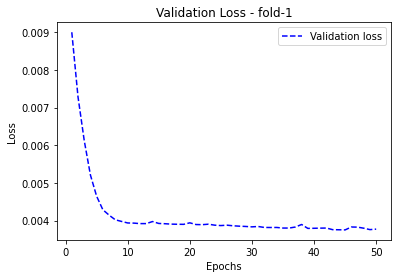

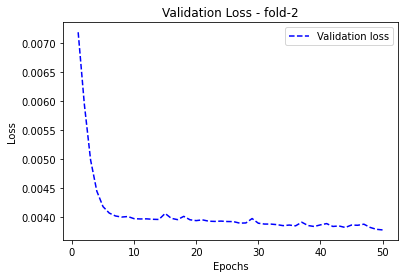

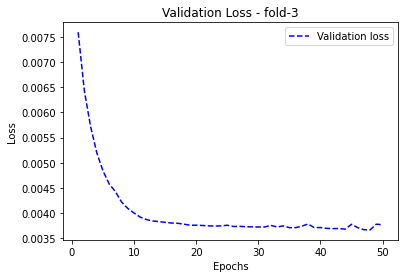

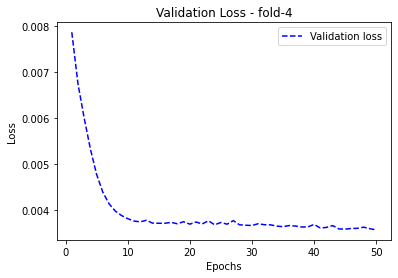

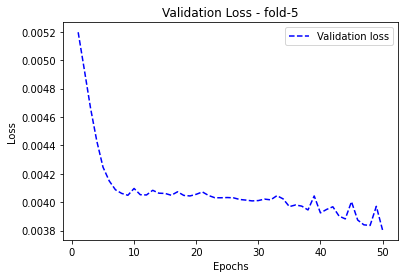

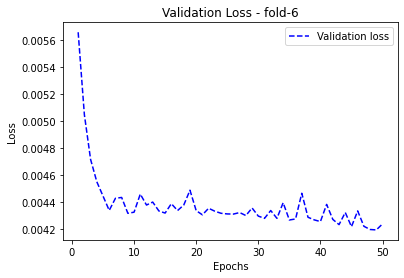

In [75]:
for val_train, val_test in kfold.split(X_train, y_train):
    # network structure
    model = models.Sequential()
    model.add(layers.Dense(64, 
              activation='relu',
              input_shape=(3,)))
    
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer='adam',
               loss='mean_squared_error', 
               metrics=['mean_absolute_percentage_error'])
    
    # output the validation results
    history = model.fit(X_train[val_train], 
                        y_train[val_train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        validation_data=(X_train[val_test], y_train[val_test]),
                        verbose=verbosity)
    
    plot_val_loss(no_epochs, history, "Validation Loss - fold-" + str(fold_no))
    
    fold_no = fold_no + 1

In [77]:
# set semi-tuned hyperparameters 
no_epochs = 10

In [78]:
# rebuild the model with the semi-tunned hyperparameter
model = models.Sequential()
model.add(layers.Dense(64, 
          activation='relu',
          input_shape=(3,)))

model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam',
           loss='mean_squared_error', 
           metrics=['mean_absolute_percentage_error'])

In [79]:
# fit the model with the whole training dataset
model.fit(X_train, y_train, 
          epochs=no_epochs, 
          batch_size=batch_size,
          verbose = 0)

In [80]:
# results of the minimum viable network
results = model.evaluate(X_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - mean_absolute_percentage_error: 12.9101 


# Building Random Walk Basline

In [81]:
# copy the exchange rate dataset
df_random = df_exh_rate.copy()

In [82]:
df_random.head()

,date,gbp_per_usd
0,1971-01-04,2.3938
1,1971-01-05,2.3949
2,1971-01-06,2.3967
3,1971-01-07,2.3963
4,1971-01-08,2.3972


In [83]:
# create a column which is the 'date' column offsetting 6 months
df_random['date_plus_6m']=df_random['date'] + pd.DateOffset(months=6)

In [84]:
df_random['date_plus_6m'] = pd.to_datetime(df_random['date_plus_6m'])

In [85]:
# get the number of days between the 'date' and the 'date plus 6 month'
df_random['num_of_days'] = (df_random['date_plus_6m'] - df_random['date']).dt.days

In [86]:
df_random.head()

,date,gbp_per_usd,date_plus_6m,num_of_days
0,1971-01-04,2.3938,1971-07-04,181
1,1971-01-05,2.3949,1971-07-05,181
2,1971-01-06,2.3967,1971-07-06,181
3,1971-01-07,2.3963,1971-07-07,181
4,1971-01-08,2.3972,1971-07-08,181


In [87]:
df_random.dtypes

date            datetime64[ns]
gbp_per_usd             object
date_plus_6m    datetime64[ns]
num_of_days              int64
dtype: object

In [88]:
df_random = df_random.sort_values(by='date')

In [89]:
df_random.head()

,date,gbp_per_usd,date_plus_6m,num_of_days
0,1971-01-04,2.3938,1971-07-04,181
1,1971-01-05,2.3949,1971-07-05,181
2,1971-01-06,2.3967,1971-07-06,181
3,1971-01-07,2.3963,1971-07-07,181
4,1971-01-08,2.3972,1971-07-08,181


In [90]:
df_random.isnull().any().any()

False

In [91]:
# replace the 'ND' value with the last exchange rate
df_random['gbp_per_usd'].replace("ND", pd.NA, inplace=True)
df_random.ffill(inplace=True)

In [93]:
df_random = df_random.astype({'gbp_per_usd': 'float'})

In [94]:
df_random.head()

,date,gbp_per_usd,date_plus_6m,num_of_days
0,1971-01-04,2.3938,1971-07-04,181
1,1971-01-05,2.3949,1971-07-05,181
2,1971-01-06,2.3967,1971-07-06,181
3,1971-01-07,2.3963,1971-07-07,181
4,1971-01-08,2.3972,1971-07-08,181


In [95]:
# get ther difference of the exchange rate
df_random['gbp_per_usd_diff'] = df_random['gbp_per_usd'].diff()

In [96]:
df_random

,date,gbp_per_usd,date_plus_6m,num_of_days,gbp_per_usd_diff
0,1971-01-04,2.3938,1971-07-04,181,NaN
1,1971-01-05,2.3949,1971-07-05,181,0.0011
2,1971-01-06,2.3967,1971-07-06,181,0.0018
3,1971-01-07,2.3963,1971-07-07,181,-0.0004
4,1971-01-08,2.3972,1971-07-08,181,0.0009
...,...,...,...,...,...
13930,2024-05-27,1.2746,2024-11-27,184,0.0000
13931,2024-05-28,1.2786,2024-11-28,184,0.0040
13932,2024-05-29,1.2714,2024-11-29,184,-0.0072
13933,2024-05-30,1.2739,2024-11-30,184,0.0025


In [97]:
df_random = df_random.drop(df.index[0])

In [98]:
# final structure of the dataset for building random walk
df_random.head()

,date,gbp_per_usd,date_plus_6m,num_of_days,gbp_per_usd_diff
1,1971-01-05,2.3949,1971-07-05,181,0.0011
2,1971-01-06,2.3967,1971-07-06,181,0.0018
3,1971-01-07,2.3963,1971-07-07,181,-0.0004
4,1971-01-08,2.3972,1971-07-08,181,0.0009
5,1971-01-11,2.3992,1971-07-11,181,0.0020


In [99]:
# get the mean of the difference
df_random['gbp_per_usd_diff'].mean()

-8.037892923783552e-05

In [100]:
# get the standard deviation of the difference
std_exh_rate = df_random['gbp_per_usd_diff'].std()

In [101]:
gbp_per_usd_random = []

In [102]:
# generate the random walk prediction by apply the normal distributed movement recursively
for index, row in df_random.iterrows():
    current_exh_rate = row['gbp_per_usd']
    for i in range(0, row['num_of_days']):
        current_exh_rate = random.normalvariate(mu=current_exh_rate,sigma=std_exh_rate)
    gbp_per_usd_random.append(current_exh_rate)        

In [103]:
df_random['gbp_per_usd_random'] = gbp_per_usd_random

In [104]:
df_random

,date,gbp_per_usd,date_plus_6m,num_of_days,gbp_per_usd_diff,gbp_per_usd_random
1,1971-01-05,2.3949,1971-07-05,181,0.0011,2.353767
2,1971-01-06,2.3967,1971-07-06,181,0.0018,2.454749
3,1971-01-07,2.3963,1971-07-07,181,-0.0004,2.395498
4,1971-01-08,2.3972,1971-07-08,181,0.0009,2.396836
5,1971-01-11,2.3992,1971-07-11,181,0.0020,2.412887
...,...,...,...,...,...,...
13930,2024-05-27,1.2746,2024-11-27,184,0.0000,1.267452
13931,2024-05-28,1.2786,2024-11-28,184,0.0040,1.420457
13932,2024-05-29,1.2714,2024-11-29,184,-0.0072,1.267331
13933,2024-05-30,1.2739,2024-11-30,184,0.0025,1.131610


In [105]:
# merge the exchange rate on the random walk dataset on the shiftted date column
df_random=df_random.merge(df_exh_rate, left_on='date_plus_6m', right_on='date', how='left')

In [106]:
df_random.head()

,date_x,gbp_per_usd_x,date_plus_6m,num_of_days,gbp_per_usd_diff,gbp_per_usd_random,date_y,gbp_per_usd_y
0,1971-01-05,2.3949,1971-07-05,181,0.0011,2.353767,1971-07-05,ND
1,1971-01-06,2.3967,1971-07-06,181,0.0018,2.454749,1971-07-06,2.4181
2,1971-01-07,2.3963,1971-07-07,181,-0.0004,2.395498,1971-07-07,2.4187
3,1971-01-08,2.3972,1971-07-08,181,0.0009,2.396836,1971-07-08,2.4185
4,1971-01-11,2.3992,1971-07-11,181,0.0020,2.412887,NaT,NaN


In [107]:
df_random.replace("ND", pd.NA, inplace = True)

In [108]:
df_random.dropna(inplace=True)

In [109]:
df_random.head()

,date_x,gbp_per_usd_x,date_plus_6m,num_of_days,gbp_per_usd_diff,gbp_per_usd_random,date_y,gbp_per_usd_y
1,1971-01-06,2.3967,1971-07-06,181,0.0018,2.454749,1971-07-06,2.4181
2,1971-01-07,2.3963,1971-07-07,181,-0.0004,2.395498,1971-07-07,2.4187
3,1971-01-08,2.3972,1971-07-08,181,0.0009,2.396836,1971-07-08,2.4185
5,1971-01-12,2.4001,1971-07-12,181,0.0009,2.292308,1971-07-12,2.4182
6,1971-01-13,2.4021,1971-07-13,181,0.0020,2.370349,1971-07-13,2.4180


In [110]:
df_random.dtypes

date_x                datetime64[ns]
gbp_per_usd_x                float64
date_plus_6m          datetime64[ns]
num_of_days                    int64
gbp_per_usd_diff             float64
gbp_per_usd_random           float64
date_y                datetime64[ns]
gbp_per_usd_y                 object
dtype: object

In [111]:
df_random = df_random.astype({'gbp_per_usd_y': 'float'})

In [112]:
df_random.dtypes

date_x                datetime64[ns]
gbp_per_usd_x                float64
date_plus_6m          datetime64[ns]
num_of_days                    int64
gbp_per_usd_diff             float64
gbp_per_usd_random           float64
date_y                datetime64[ns]
gbp_per_usd_y                float64
dtype: object

In [113]:
df_random.rename(columns={'date_x': 'date', 
                          'gbp_per_usd_x': 'gbp_per_usd',
                          'gbp_per_usd_y': 'gbp_per_usd_6m'}, inplace=True)

In [114]:
df_random.drop(columns=['date_y'], inplace=True)

In [115]:
df_random.head()

,date,gbp_per_usd,date_plus_6m,num_of_days,gbp_per_usd_diff,gbp_per_usd_random,gbp_per_usd_6m
1,1971-01-06,2.3967,1971-07-06,181,0.0018,2.454749,2.4181
2,1971-01-07,2.3963,1971-07-07,181,-0.0004,2.395498,2.4187
3,1971-01-08,2.3972,1971-07-08,181,0.0009,2.396836,2.4185
5,1971-01-12,2.4001,1971-07-12,181,0.0009,2.292308,2.4182
6,1971-01-13,2.4021,1971-07-13,181,0.0020,2.370349,2.4180


In [116]:
# compute the mape of the Random Walk model
mape = (abs((df_random['gbp_per_usd_6m'] - df_random['gbp_per_usd_random']) / df_random['gbp_per_usd_6m']) * 100).mean()

In [117]:
mape

8.656078134565401

# Adding more fundamentals to the network

## Load Data

### CPI dataset

In [118]:
# read the dataset of CPI of the UK
df_CPI_UK=pd.read_csv('./data/CPI_UK.csv')

In [119]:
# the data structure of the CPI dataset
df_CPI_UK.head(10)

,Title,CPI INDEX 00: ALL ITEMS 2015=100
0,CDID,D7BT
1,Source dataset ID,MM23
2,PreUnit,NaN
3,Unit,"Index, base year = 100"
4,Release date,17-07-2024
5,Next release,14 August 2024
6,Important notes,NaN
7,1988,49.6
8,1989,52.2
9,1990,55.9


In [120]:
# remove the information header
df_CPI_UK = df_CPI_UK[7:]

In [121]:
df_CPI_UK.head()

,Title,CPI INDEX 00: ALL ITEMS 2015=100
7,1988,49.6
8,1989,52.2
9,1990,55.9
10,1991,60.1
11,1992,62.6


In [122]:
# remove the yearly CPI data of the UK
df_CPI_UK = df_CPI_UK[2023-1988+1:]

In [123]:
df_CPI_UK.head()

,Title,CPI INDEX 00: ALL ITEMS 2015=100
43,1988 Q1,48.6
44,1988 Q2,49.5
45,1988 Q3,49.9
46,1988 Q4,50.5
47,1989 Q1,51.0


In [124]:
# remove the quarterly CPI data of the UK
df_CPI_UK = df_CPI_UK[(2023-1988+1) * 4:]

In [125]:
df_CPI_UK.head()

,Title,CPI INDEX 00: ALL ITEMS 2015=100
187,2024 Q1,132.3
188,2024 Q2,133.8
189,1988 JAN,48.4
190,1988 FEB,48.6
191,1988 MAR,48.7


In [126]:
df_CPI_UK = df_CPI_UK[2:]

In [127]:
df_CPI_UK.head()

,Title,CPI INDEX 00: ALL ITEMS 2015=100
189,1988 JAN,48.4
190,1988 FEB,48.6
191,1988 MAR,48.7
192,1988 APR,49.3
193,1988 MAY,49.5


In [128]:
df_CPI_UK.rename(columns={'Title': 'date', 'CPI INDEX 00: ALL ITEMS 2015=100': 'CPI_UK'}, inplace=True)

In [129]:
df_CPI_UK.head()

,date,CPI_UK
189,1988 JAN,48.4
190,1988 FEB,48.6
191,1988 MAR,48.7
192,1988 APR,49.3
193,1988 MAY,49.5


In [130]:
df_CPI_UK['date'] = pd.to_datetime(df_CPI_UK['date'], format='%Y %b')

In [131]:
df_CPI_UK.head()

,date,CPI_UK
189,1988-01-01,48.4
190,1988-02-01,48.6
191,1988-03-01,48.7
192,1988-04-01,49.3
193,1988-05-01,49.5


In [134]:
df_CPI_UK = df_CPI_UK.reindex()

In [135]:
df_CPI_UK.head()

,date,CPI_UK
189,1988-01-01,48.4
190,1988-02-01,48.6
191,1988-03-01,48.7
192,1988-04-01,49.3
193,1988-05-01,49.5


In [136]:
df_CPI_UK = df_CPI_UK.reset_index(drop=True)

In [137]:
# final structe of the CPI data of the UK
df_CPI_UK.head()

,date,CPI_UK
0,1988-01-01,48.4
1,1988-02-01,48.6
2,1988-03-01,48.7
3,1988-04-01,49.3
4,1988-05-01,49.5


In [138]:
df_CPI_UK.dtypes

date      datetime64[ns]
CPI_UK            object
dtype: object

In [139]:
df_CPI_UK = df_CPI_UK.astype({'CPI_UK': 'float'})

In [140]:
df_CPI_UK.dtypes

date      datetime64[ns]
CPI_UK           float64
dtype: object

In [141]:
df_CPI_UK.isnull().any().any()

False

In [142]:
# read the dataset of CPI of the US
df_CPI_US=pd.read_csv('./data/CPI_US.csv')

In [143]:
df_CPI_US.head()

,DATE,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [144]:
df_CPI_US.isnull().any().any()

False

In [145]:
df_CPI_US.rename(columns={'DATE': 'date', 'CPIAUCSL': 'CPI_US'}, inplace=True)

In [146]:
# final structure of the CPI dataset of the US
df_CPI_US.head()

,date,CPI_US
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [147]:
df_CPI_US['date'] = pd.to_datetime(df_CPI_US['date'])
df_CPI_UK['date'] = pd.to_datetime(df_CPI_UK['date'])

#### GDP dataset ####

In [148]:
df_GDP = pd.read_csv('./data/GDP.csv', skiprows=4)

In [149]:
df_GDP.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.558906e+09,3.103184e+09,3.544708e+09,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.121696e+10,2.230747e+10,2.370247e+10,2.577938e+10,2.804954e+10,3.037491e+10,...,8.992957e+11,8.298300e+11,9.401055e+11,1.012719e+12,1.006527e+12,9.290741e+11,1.086772e+12,1.183962e+12,1.236163e+12,NaN
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426650e+10,1.450216e+10,NaN,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.188413e+10,1.268566e+10,1.360683e+10,1.443998e+10,1.576911e+10,1.693448e+10,...,7.693673e+11,6.921811e+11,6.857502e+11,7.681896e+11,8.239336e+11,7.871467e+11,8.459930e+11,8.771408e+11,7.965862e+11,NaN
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,9.049642e+10,5.276162e+10,7.369015e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,8.472296e+10,NaN


In [150]:
df_GDP = df_GDP[df_GDP['Country Name'].isin(['United States', 'United Kingdom'])]

In [151]:
df_GDP

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
81,United Kingdom,GBR,GDP (current US$),NY.GDP.MKTP.CD,7.323397e+10,7.774197e+10,8.124756e+10,8.656196e+10,9.440756e+10,1.018248e+11,...,2.927911e+12,2.689107e+12,2.680148e+12,2.871340e+12,2.851407e+12,2.697807e+12,3.141506e+12,3.088840e+12,3.340032e+12,NaN
251,United States,USA,GDP (current US$),NY.GDP.MKTP.CD,5.419886e+11,5.619403e+11,6.036394e+11,6.370586e+11,6.841446e+11,7.419049e+11,...,1.829502e+13,1.880491e+13,1.961210e+13,2.065652e+13,2.152140e+13,2.132295e+13,2.359403e+13,2.574411e+13,2.736094e+13,NaN


In [152]:
df_GDP.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 68'],inplace=True)

In [153]:
df_GDP

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
81,United Kingdom,7.323397e+10,7.774197e+10,8.124756e+10,8.656196e+10,9.440756e+10,1.018248e+11,1.085728e+11,1.131169e+11,1.077599e+11,...,3.064708e+12,2.927911e+12,2.689107e+12,2.680148e+12,2.871340e+12,2.851407e+12,2.697807e+12,3.141506e+12,3.088840e+12,3.340032e+12
251,United States,5.419886e+11,5.619403e+11,6.036394e+11,6.370586e+11,6.841446e+11,7.419049e+11,8.130328e+11,8.596200e+11,9.402250e+11,...,1.760814e+13,1.829502e+13,1.880491e+13,1.961210e+13,2.065652e+13,2.152140e+13,2.132295e+13,2.359403e+13,2.574411e+13,2.736094e+13


In [154]:
# transform the dataset from horizontal to vertical
df_GDP = df_GDP.melt(id_vars=['Country Name'], 
                     var_name='Year', 
                     value_name='GDP')

In [155]:
df_GDP_US = df_GDP[df_GDP['Country Name'] == 'United States']

In [156]:
df_GDP_US.head()

,Country Name,Year,GDP
1,United States,1960,5.419886e+11
3,United States,1961,5.619403e+11
5,United States,1962,6.036394e+11
7,United States,1963,6.370586e+11
9,United States,1964,6.841446e+11


In [157]:
df_GDP_US.drop(columns=['Country Name'], inplace=True)

C:\Users\ngkah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [158]:
df_GDP_US.head()

,Year,GDP
1,1960,5.419886e+11
3,1961,5.619403e+11
5,1962,6.036394e+11
7,1963,6.370586e+11
9,1964,6.841446e+11


In [159]:
df_GDP_US.rename(columns={'Year': 'date', 'GDP': 'GDP_US'})

,date,GDP_US
1,1960,5.419886e+11
3,1961,5.619403e+11
5,1962,6.036394e+11
7,1963,6.370586e+11
9,1964,6.841446e+11
...,...,...
119,2019,2.152140e+13
121,2020,2.132295e+13
123,2021,2.359403e+13
125,2022,2.574411e+13


In [160]:
df_GDP_US.reset_index(drop=True)

,Year,GDP
0,1960,5.419886e+11
1,1961,5.619403e+11
2,1962,6.036394e+11
3,1963,6.370586e+11
4,1964,6.841446e+11
...,...,...
59,2019,2.152140e+13
60,2020,2.132295e+13
61,2021,2.359403e+13
62,2022,2.574411e+13


In [161]:
df_GDP_US.head()

,Year,GDP
1,1960,5.419886e+11
3,1961,5.619403e+11
5,1962,6.036394e+11
7,1963,6.370586e+11
9,1964,6.841446e+11


In [162]:
df_GDP_UK = df_GDP[df_GDP['Country Name'] == 'United Kingdom']

In [163]:
df_GDP_UK.head()

,Country Name,Year,GDP
0,United Kingdom,1960,7.323397e+10
2,United Kingdom,1961,7.774197e+10
4,United Kingdom,1962,8.124756e+10
6,United Kingdom,1963,8.656196e+10
8,United Kingdom,1964,9.440756e+10


In [164]:
df_GDP_UK.drop(columns=['Country Name'], inplace=True)
df_GDP_UK.rename(columns={'Year': 'date', 'GDP': 'GDP_US'})
df_GDP_UK.reset_index(drop=True)

C:\Users\ngkah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,GDP
0,1960,7.323397e+10
1,1961,7.774197e+10
2,1962,8.124756e+10
3,1963,8.656196e+10
4,1964,9.440756e+10
...,...,...
59,2019,2.851407e+12
60,2020,2.697807e+12
61,2021,3.141506e+12
62,2022,3.088840e+12


since the values of GDP is too big, normalization is needed

In [165]:
# normalize the GDP since it is too large comparing to other variabels
df_GDP_US['Normalized GDP'] = (df_GDP_US['GDP'] - df_GDP_US['GDP'].min()) / (df_GDP_US['GDP'].max() - df_GDP_US['GDP'].min())

C:\Users\ngkah\AppData\Local\Temp/ipykernel_13700/3981377650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GDP_US['Normalized GDP'] = (df_GDP_US['GDP'] - df_GDP_US['GDP'].min()) / (df_GDP_US['GDP'].max() - df_GDP_US['GDP'].min())


In [166]:
df_GDP_US.tail()

,Year,GDP,Normalized GDP
119,2019,2.152140e+13,0.782261
121,2020,2.132295e+13,0.774861
123,2021,2.359403e+13,0.859543
125,2022,2.574411e+13,0.939713
127,2023,2.736094e+13,1.000000


In [167]:
# normalize the GDP since it is too large comparing to other variabels
df_GDP_UK['Normalized GDP'] = (df_GDP_UK['GDP'] - df_GDP_UK['GDP'].min()) / (df_GDP_UK['GDP'].max() - df_GDP_UK['GDP'].min())

C:\Users\ngkah\AppData\Local\Temp/ipykernel_13700/4073353427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GDP_UK['Normalized GDP'] = (df_GDP_UK['GDP'] - df_GDP_UK['GDP'].min()) / (df_GDP_UK['GDP'].max() - df_GDP_UK['GDP'].min())


In [168]:
df_GDP_UK.head()

,Year,GDP,Normalized GDP
0,1960,7.323397e+10,0.000000
2,1961,7.774197e+10,0.001380
4,1962,8.124756e+10,0.002453
6,1963,8.656196e+10,0.004080
8,1964,9.440756e+10,0.006481


In [169]:
df_GDP_UK.tail()

,Year,GDP,Normalized GDP
118,2019,2.851407e+12,0.850427
120,2020,2.697807e+12,0.803408
122,2021,3.141506e+12,0.939229
124,2022,3.088840e+12,0.923107
126,2023,3.340032e+12,1.000000


#### create a date column for the dataset ####

In [170]:
# the date of the GDP is the first date of the year
df_GDP_US['date'] = pd.to_datetime(df_GDP_US['Year'].astype(str) + '-01-01')

C:\Users\ngkah\AppData\Local\Temp/ipykernel_13700/31399369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GDP_US['date'] = pd.to_datetime(df_GDP_US['Year'].astype(str) + '-01-01')


In [171]:
df_GDP_US.head()

,Year,GDP,Normalized GDP,date
1,1960,5.419886e+11,0.000000,1960-01-01
3,1961,5.619403e+11,0.000744,1961-01-01
5,1962,6.036394e+11,0.002299,1962-01-01
7,1963,6.370586e+11,0.003545,1963-01-01
9,1964,6.841446e+11,0.005301,1964-01-01


In [172]:
df_GDP_US.tail()

,Year,GDP,Normalized GDP,date
119,2019,2.152140e+13,0.782261,2019-01-01
121,2020,2.132295e+13,0.774861,2020-01-01
123,2021,2.359403e+13,0.859543,2021-01-01
125,2022,2.574411e+13,0.939713,2022-01-01
127,2023,2.736094e+13,1.000000,2023-01-01


In [173]:
# the date of the GDP is the first date of the year
df_GDP_UK['date'] = pd.to_datetime(df_GDP_UK['Year'].astype(str) + '-01-01')

C:\Users\ngkah\AppData\Local\Temp/ipykernel_13700/4205346688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GDP_UK['date'] = pd.to_datetime(df_GDP_UK['Year'].astype(str) + '-01-01')


In [174]:
df_GDP_US.head()

,Year,GDP,Normalized GDP,date
1,1960,5.419886e+11,0.000000,1960-01-01
3,1961,5.619403e+11,0.000744,1961-01-01
5,1962,6.036394e+11,0.002299,1962-01-01
7,1963,6.370586e+11,0.003545,1963-01-01
9,1964,6.841446e+11,0.005301,1964-01-01


In [175]:
df_GDP_US.tail()

,Year,GDP,Normalized GDP,date
119,2019,2.152140e+13,0.782261,2019-01-01
121,2020,2.132295e+13,0.774861,2020-01-01
123,2021,2.359403e+13,0.859543,2021-01-01
125,2022,2.574411e+13,0.939713,2022-01-01
127,2023,2.736094e+13,1.000000,2023-01-01


In [176]:
df_GDP_US = df_GDP_US[['date', 'Normalized GDP', ]]
df_GDP_UK= df_GDP_UK[['date', 'Normalized GDP']]

In [177]:
df_GDP_US.rename(columns={'Normalized GDP': 'GDP_US'}, 
                 inplace=True)
df_GDP_UK.rename(columns={'Normalized GDP': 'GDP_UK'}, 
                 inplace=True)

In [178]:
# final structure of the GDP dataset of the US
df_GDP_US.head()

,date,GDP_US
1,1960-01-01,0.000000
3,1961-01-01,0.000744
5,1962-01-01,0.002299
7,1963-01-01,0.003545
9,1964-01-01,0.005301


In [179]:
# final structure of the GDP dataset of the UK
df_GDP_UK.head()

,date,GDP_UK
0,1960-01-01,0.000000
2,1961-01-01,0.001380
4,1962-01-01,0.002453
6,1963-01-01,0.004080
8,1964-01-01,0.006481


## Enriching the dataset ##

In [180]:
# starting from the exchange rate dataset
df_expand = df_exh_rate.copy()

In [181]:
df_expand.head()

,date,gbp_per_usd
0,1971-01-04,2.3938
1,1971-01-05,2.3949
2,1971-01-06,2.3967
3,1971-01-07,2.3963
4,1971-01-08,2.3972


In [182]:
df_expand.tail()

,date,gbp_per_usd
13930,2024-05-27,ND
13931,2024-05-28,1.2786
13932,2024-05-29,1.2714
13933,2024-05-30,1.2739
13934,2024-05-31,1.2738


In [183]:
df_expand.dtypes

date           datetime64[ns]
gbp_per_usd            object
dtype: object

In [184]:
# create a 'date plus 6m' column by offsetting the 'date' column 6 months
df_expand['date_plus_6m']=df_expand['date'] + pd.DateOffset(months=6)

In [185]:
df_expand.head()

,date,gbp_per_usd,date_plus_6m
0,1971-01-04,2.3938,1971-07-04
1,1971-01-05,2.3949,1971-07-05
2,1971-01-06,2.3967,1971-07-06
3,1971-01-07,2.3963,1971-07-07
4,1971-01-08,2.3972,1971-07-08


In [186]:
# map the exchange rate on the column 'date_plus_6m' to be the exchange rate of the 'date' column 6 months after
df_expand=df_expand.merge(df_exh_rate, left_on='date_plus_6m', right_on='date', how='left')

In [187]:
df_exh_rate.head()

,date,gbp_per_usd
0,1971-01-04,2.3938
1,1971-01-05,2.3949
2,1971-01-06,2.3967
3,1971-01-07,2.3963
4,1971-01-08,2.3972


In [188]:
df_expand.head()

,date_x,gbp_per_usd_x,date_plus_6m,date_y,gbp_per_usd_y
0,1971-01-04,2.3938,1971-07-04,NaT,NaN
1,1971-01-05,2.3949,1971-07-05,1971-07-05,ND
2,1971-01-06,2.3967,1971-07-06,1971-07-06,2.4181
3,1971-01-07,2.3963,1971-07-07,1971-07-07,2.4187
4,1971-01-08,2.3972,1971-07-08,1971-07-08,2.4185


In [189]:
df_expand.drop(columns=['date_y'], inplace=True)

In [190]:
df_expand.head()

,date_x,gbp_per_usd_x,date_plus_6m,gbp_per_usd_y
0,1971-01-04,2.3938,1971-07-04,NaN
1,1971-01-05,2.3949,1971-07-05,ND
2,1971-01-06,2.3967,1971-07-06,2.4181
3,1971-01-07,2.3963,1971-07-07,2.4187
4,1971-01-08,2.3972,1971-07-08,2.4185


In [191]:
df_expand.rename(columns={'date_x': 'date', 
                          'gbp_per_usd_x': 'gbp_per_usd', 
                          'gbp_per_usd_y': 'gbp_per_usd_plus_6m'},
                 inplace=True)

In [192]:
df_expand.head()

,date,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m
0,1971-01-04,2.3938,1971-07-04,NaN
1,1971-01-05,2.3949,1971-07-05,ND
2,1971-01-06,2.3967,1971-07-06,2.4181
3,1971-01-07,2.3963,1971-07-07,2.4187
4,1971-01-08,2.3972,1971-07-08,2.4185


In [193]:
# create a 'date_cpi' column for mapping the CPI data
df_expand['date_cpi'] = df_expand['date'].dt.to_period('M').dt.to_timestamp()

In [194]:
df_expand.head()

,date,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01


In [195]:
# create a 'date_gdp' column for mapping the GDP data
df_expand['date_gdp'] = df_expand['date'].dt.to_period('Y').dt.to_timestamp()

In [196]:
df_expand.head()

,date,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01


In [197]:
# mapping the gdp dataset to the exchange rate dataset on the 'date_gdp' column
df_expand = df_expand.merge(df_GDP_US, left_on='date_gdp', right_on='date', how='left')

In [198]:
df_expand.head()

,date_x,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,date_y,GDP_US
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01,1971-01-01,0.023225
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01,1971-01-01,0.023225
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01,1971-01-01,0.023225
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01,1971-01-01,0.023225
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01,1971-01-01,0.023225


In [199]:
# mapping the gdp dataset to the exchange rate dataset on the 'date_gdp' column
df_expand = df_expand.merge(df_GDP_UK, left_on='date_gdp', right_on='date', how='left')

In [200]:
df_expand.head()

,date_x,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,date_y,GDP_US,date,GDP_UK
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01,1971-01-01,0.023225,1971-01-01,0.022922
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01,1971-01-01,0.023225,1971-01-01,0.022922
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01,1971-01-01,0.023225,1971-01-01,0.022922
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01,1971-01-01,0.023225,1971-01-01,0.022922
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01,1971-01-01,0.023225,1971-01-01,0.022922


In [201]:
df_CPI_US.dtypes

date      datetime64[ns]
CPI_US           float64
dtype: object

In [202]:
df_expand=df_expand[['date_x', 
                     'gbp_per_usd', 
                     'date_plus_6m',
                     'gbp_per_usd_plus_6m',
                     'date_cpi', 
                     'date_gdp',
                     'GDP_US',
                     'GDP_UK']]

In [203]:
df_expand.head()

,date_x,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,GDP_US,GDP_UK
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01,0.023225,0.022922
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01,0.023225,0.022922
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01,0.023225,0.022922
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01,0.023225,0.022922
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01,0.023225,0.022922


In [204]:
df_expand.rename(columns={'date_x': 'date'}, inplace=True)

In [205]:
df_expand.head()

,date,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,GDP_US,GDP_UK
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01,0.023225,0.022922
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01,0.023225,0.022922
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01,0.023225,0.022922
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01,0.023225,0.022922
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01,0.023225,0.022922


In [206]:
# mapping the CPI dataset to the exchange rate dataset on the 'date_cpi' column
df_expand = df_expand.merge(df_CPI_US, 
                            left_on='date_cpi',
                            right_on='date',
                            how='left')

In [207]:
df_expand.head()

,date_x,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,GDP_US,GDP_UK,date_y,CPI_US
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01,0.023225,0.022922,1971-01-01,39.9
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01,0.023225,0.022922,1971-01-01,39.9
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01,0.023225,0.022922,1971-01-01,39.9
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01,0.023225,0.022922,1971-01-01,39.9
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01,0.023225,0.022922,1971-01-01,39.9


In [208]:
df_expand.drop(columns='date_y', inplace=True)
df_expand.rename(columns={'date_x': 'date'}, inplace=True)

In [209]:
df_expand.head()

,date,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,GDP_US,GDP_UK,CPI_US
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01,0.023225,0.022922,39.9
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01,0.023225,0.022922,39.9
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01,0.023225,0.022922,39.9
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01,0.023225,0.022922,39.9
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01,0.023225,0.022922,39.9


In [210]:
# mapping the CPI dataset to the exchange rate dataset on the 'date_cpi' column
df_expand = df_expand.merge(df_CPI_UK, 
                            left_on='date_cpi',
                            right_on='date',
                            how='left')

In [211]:
df_expand.head()

,date_x,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,GDP_US,GDP_UK,CPI_US,date_y,CPI_UK
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaT,NaN
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaT,NaN
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaT,NaN
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaT,NaN
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaT,NaN


In [212]:
df_expand.drop(columns='date_y', inplace=True)
df_expand.rename(columns={'date_x': 'date'}, inplace=True)

In [213]:
df_expand.head()

,date,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,GDP_US,GDP_UK,CPI_US,CPI_UK
0,1971-01-04,2.3938,1971-07-04,NaN,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaN
1,1971-01-05,2.3949,1971-07-05,ND,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaN
2,1971-01-06,2.3967,1971-07-06,2.4181,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaN
3,1971-01-07,2.3963,1971-07-07,2.4187,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaN
4,1971-01-08,2.3972,1971-07-08,2.4185,1971-01-01,1971-01-01,0.023225,0.022922,39.9,NaN


In [214]:
df_expand.tail()

,date,gbp_per_usd,date_plus_6m,gbp_per_usd_plus_6m,date_cpi,date_gdp,GDP_US,GDP_UK,CPI_US,CPI_UK
13930,2024-05-27,ND,2024-11-27,NaN,2024-05-01,2024-01-01,NaN,NaN,313.225,133.9
13931,2024-05-28,1.2786,2024-11-28,NaN,2024-05-01,2024-01-01,NaN,NaN,313.225,133.9
13932,2024-05-29,1.2714,2024-11-29,NaN,2024-05-01,2024-01-01,NaN,NaN,313.225,133.9
13933,2024-05-30,1.2739,2024-11-30,NaN,2024-05-01,2024-01-01,NaN,NaN,313.225,133.9
13934,2024-05-31,1.2738,2024-11-30,NaN,2024-05-01,2024-01-01,NaN,NaN,313.225,133.9


In [215]:
df_expand.drop(columns=['date_plus_6m', 'date_cpi', 'date_gdp'] , inplace=True)

In [216]:
df_expand.head()

,date,gbp_per_usd,gbp_per_usd_plus_6m,GDP_US,GDP_UK,CPI_US,CPI_UK
0,1971-01-04,2.3938,NaN,0.023225,0.022922,39.9,NaN
1,1971-01-05,2.3949,ND,0.023225,0.022922,39.9,NaN
2,1971-01-06,2.3967,2.4181,0.023225,0.022922,39.9,NaN
3,1971-01-07,2.3963,2.4187,0.023225,0.022922,39.9,NaN
4,1971-01-08,2.3972,2.4185,0.023225,0.022922,39.9,NaN


In [217]:
# mapping the USD interest rate dataset to the exchange rate dataset on the 'date' column
df_expand=df_expand.merge(df_usd_int, on='date', how='left')

In [218]:
df_expand.head()

,date,gbp_per_usd,gbp_per_usd_plus_6m,GDP_US,GDP_UK,CPI_US,CPI_UK,6m_usd_int_rate
0,1971-01-04,2.3938,NaN,0.023225,0.022922,39.9,NaN,NaN
1,1971-01-05,2.3949,ND,0.023225,0.022922,39.9,NaN,NaN
2,1971-01-06,2.3967,2.4181,0.023225,0.022922,39.9,NaN,NaN
3,1971-01-07,2.3963,2.4187,0.023225,0.022922,39.9,NaN,NaN
4,1971-01-08,2.3972,2.4185,0.023225,0.022922,39.9,NaN,NaN


In [219]:
# mapping the GBP interest rate dataset to the exchange rate dataset on the 'date' column
df_expand=df_expand.merge(df_gbp_int, on='date', how='left')

In [220]:
df_expand.head()

,date,gbp_per_usd,gbp_per_usd_plus_6m,GDP_US,GDP_UK,CPI_US,CPI_UK,6m_usd_int_rate,6m_gbp_int_rate
0,1971-01-04,2.3938,NaN,0.023225,0.022922,39.9,NaN,NaN,NaN
1,1971-01-05,2.3949,ND,0.023225,0.022922,39.9,NaN,NaN,NaN
2,1971-01-06,2.3967,2.4181,0.023225,0.022922,39.9,NaN,NaN,NaN
3,1971-01-07,2.3963,2.4187,0.023225,0.022922,39.9,NaN,NaN,NaN
4,1971-01-08,2.3972,2.4185,0.023225,0.022922,39.9,NaN,NaN,NaN


In [221]:
# convert all non-numeric data to NaN
for col in df_expand.columns:
    if col != 'date':
        df_expand[col] = pd.to_numeric(df_expand[col], errors='coerce')

In [222]:
df_expand.head()

,date,gbp_per_usd,gbp_per_usd_plus_6m,GDP_US,GDP_UK,CPI_US,CPI_UK,6m_usd_int_rate,6m_gbp_int_rate
0,1971-01-04,2.3938,NaN,0.023225,0.022922,39.9,NaN,NaN,NaN
1,1971-01-05,2.3949,NaN,0.023225,0.022922,39.9,NaN,NaN,NaN
2,1971-01-06,2.3967,2.4181,0.023225,0.022922,39.9,NaN,NaN,NaN
3,1971-01-07,2.3963,2.4187,0.023225,0.022922,39.9,NaN,NaN,NaN
4,1971-01-08,2.3972,2.4185,0.023225,0.022922,39.9,NaN,NaN,NaN


In [223]:
# drop all N/A value
df_expand=df_expand.dropna()

In [224]:
# final structure of the enriched dataset
df_expand.head()

,date,gbp_per_usd,gbp_per_usd_plus_6m,GDP_US,GDP_UK,CPI_US,CPI_UK,6m_usd_int_rate,6m_gbp_int_rate
5092,1990-07-11,1.7980,1.9070,0.202139,0.312213,130.5,55.8,8.15,13.924546
5095,1990-07-16,1.8040,1.9047,0.202139,0.312213,130.5,55.8,7.91,13.757289
5096,1990-07-17,1.8112,1.9228,0.202139,0.312213,130.5,55.8,7.91,13.700931
5097,1990-07-18,1.8205,1.9416,0.202139,0.312213,130.5,55.8,7.88,13.768089
5100,1990-07-23,1.8205,1.9550,0.202139,0.312213,130.5,55.8,7.78,13.729768


In [225]:
# number of records for the dataset
df_expand.shape

(5125, 9)

In [226]:
df_expand = df_expand.reset_index(drop=True)

## Rebuild the model with enriched dataset

In [227]:
# get the training and the target dataset
X=df_expand.drop(columns=['date','gbp_per_usd_plus_6m'])
y=df_expand['gbp_per_usd_plus_6m']

In [228]:
X.shape

(5125, 7)

In [229]:
X.head()

,gbp_per_usd,GDP_US,GDP_UK,CPI_US,CPI_UK,6m_usd_int_rate,6m_gbp_int_rate
0,1.7980,0.202139,0.312213,130.5,55.8,8.15,13.924546
1,1.8040,0.202139,0.312213,130.5,55.8,7.91,13.757289
2,1.8112,0.202139,0.312213,130.5,55.8,7.91,13.700931
3,1.8205,0.202139,0.312213,130.5,55.8,7.88,13.768089
4,1.8205,0.202139,0.312213,130.5,55.8,7.78,13.729768


In [230]:
y.head()

0    1.9070
1    1.9047
2    1.9228
3    1.9416
4    1.9550
Name: gbp_per_usd_plus_6m, dtype: float64

In [231]:
# change to array for deep learning
X=X.to_numpy()
y=y.to_numpy()

In [232]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [233]:
# set hyperparameters
num_folds = 6
no_epochs = 50
batch_size = 50
verbosity = 0

In [234]:
# folds for k-fold validation
kfold = KFold(n_splits=num_folds, shuffle=True)

In [236]:
# Function for tunning 2-layer model
def model_tuner_2_layer(layer_units, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Dense(layer_units, activation="relu", input_shape=(7, )))

    model.add(layers.Dense(1, activation="linear"))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                       loss='mean_squared_error', 
                       metrics=['mean_absolute_percentage_error'])
    return model

In [237]:
# just using hold out for the achitecture tuning
# Setting aside a validation set - Hold-out
val_X = X_train[:int(len(y_train) * 0.2)]
partial_train_X = X_train[int(len(y_train) * 0.2):]

val_y = y_train[:int(len(y_train) * 0.2)]
partial_train_y = y_train[int(len(y_train) * 0.2):]

#### Tune the achitecture ####

- trying 2-layers and 3-layers networks with different number of neurons

C:\Users\ngkah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


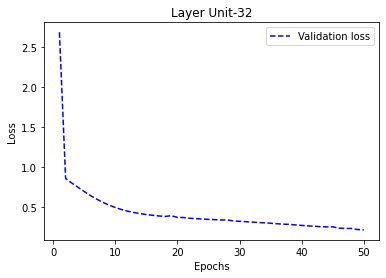

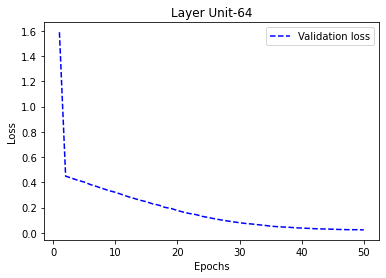

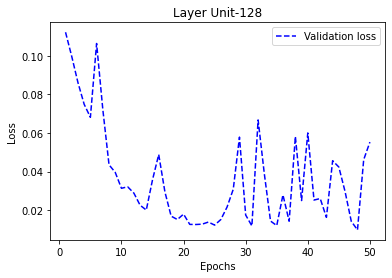

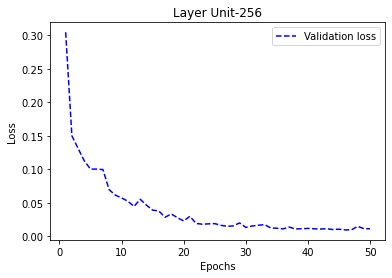

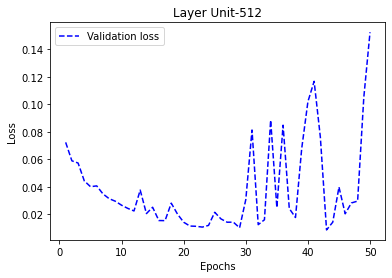

In [238]:
# tuning the architecture, trying 2-layers network with different number of neurons
for layer_units in [2**i for i in range(5, 10)]:
    model = model_tuner_2_layer(layer_units)
    history = model.fit(partial_train_X, 
                        partial_train_y,
                        batch_size=batch_size,
                        epochs=no_epochs,
                        validation_data=(val_X, val_y),
                        verbose=verbosity)

    plot_val_loss(no_epochs, history, f'Layer Unit-{layer_units}')

In [239]:
# Function for tunning 3-layer model
def model_tuner_3_layer(layer_units, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Dense(layer_units, activation="relu", input_shape=(7, )))
    model.add(layers.Dense(int(layer_units/4), activation="relu", input_shape=(7, )))
    model.add(layers.Dense(1, activation="linear"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                       loss='mean_squared_error', 
                       metrics=['mean_absolute_percentage_error'])
    return model

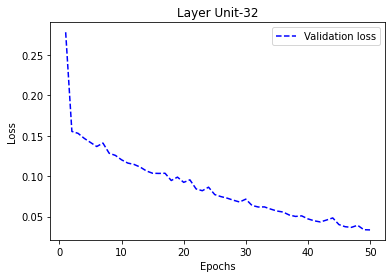

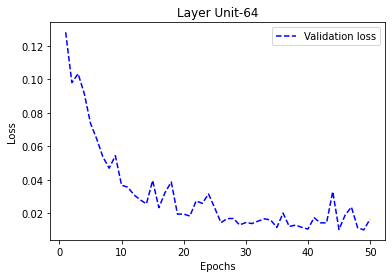

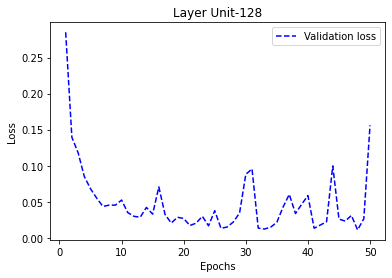

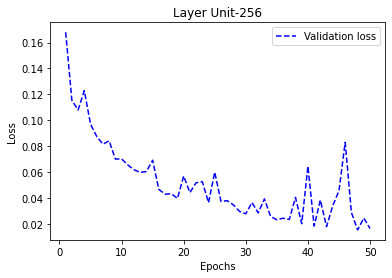

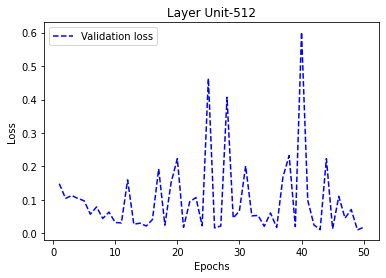

In [240]:
# tuning the architecture, trying 3-layers network with different number of neurons
for layer_units in [2**i for i in range(5, 10)]:
    model = model_tuner_3_layer(layer_units)
    history = model.fit(partial_train_X, 
                        partial_train_y,
                        batch_size=batch_size,
                        epochs=no_epochs,
                        validation_data=(val_X, val_y),
                        verbose=verbosity)

    plot_val_loss(no_epochs, history, f'Layer Unit-{layer_units}')

#### It seems the model with 3 layers overfitting to much and the loss value is jumping around. ####
#### I would like to choose 2 layers with layer unit = 128 as the model achitecture. ####

#### Tune the epoch

- Uning K-fold

In [241]:
no_epochs = 100
layer_units = 128

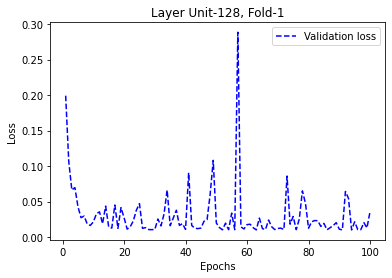

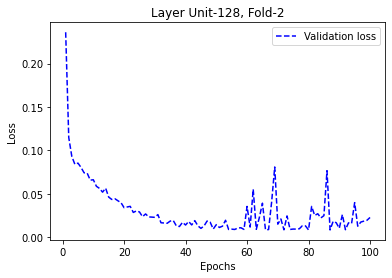

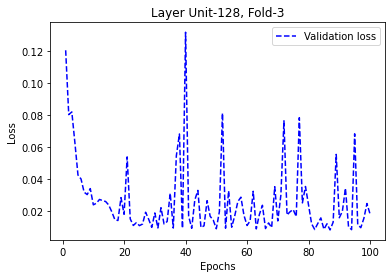

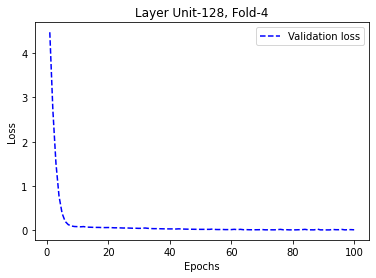

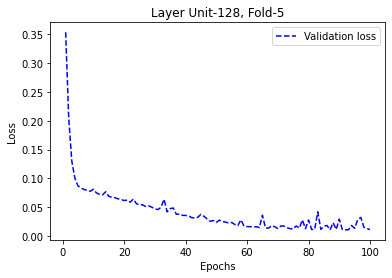

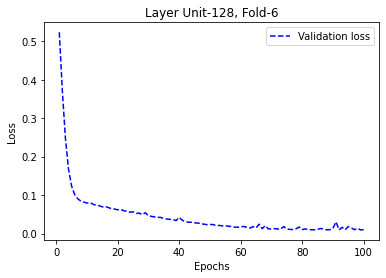

In [242]:
# initialize the fold
fold_no = 1
# print('layer_units: ', layer_units)
for val_train, val_test in kfold.split(X_train, y_train):
    model = model_tuner_2_layer(layer_units)
    history = model.fit(X_train[val_train], 
                        y_train[val_train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        validation_data=(X_train[val_test], y_train[val_test]),
                        verbose=verbosity)

    plot_val_loss(no_epochs, history, f'Layer Unit-{layer_units}, Fold-{fold_no}')

    fold_no = fold_no + 1

#### The model stops improving when numebr of epoches is around 50. ####

### Tune the batch size ###
Starting with:
- architectures: 2-layers
- layer Units: 128
- epoch: 50

In [243]:
no_epochs = 50
layer_units = 128

In [244]:
for batch_size in [10 * i for i in range(2, 8)]:
    fold_no = 1
    mean_absolute_percentage_error = 0
    for val_train, val_test in kfold.split(X_train, y_train):
        model = model_tuner_2_layer(layer_units)
        history = model.fit(X_train[val_train], 
                            y_train[val_train],
                            batch_size=batch_size,
                            epochs=no_epochs,
                            validation_data=(X_train[val_test], y_train[val_test]),
                            verbose=verbosity)
        
        mean_absolute_percentage_error += history.history['mean_absolute_percentage_error'][-1]
        print (f"Batch Size: {batch_size},  fold_no: {fold_no}, error: {history.history['mean_absolute_percentage_error'][-1]}")
        fold_no = fold_no + 1
    avg_abs_error = mean_absolute_percentage_error / num_folds
    print(f'Batch Size: {batch_size},  average error: {avg_abs_error}\n')

Batch Size: 20,  fold_no: 1, error: 7.603827953338623
Batch Size: 20,  fold_no: 2, error: 8.1461820602417
Batch Size: 20,  fold_no: 3, error: 8.285327911376953
Batch Size: 20,  fold_no: 4, error: 7.3260040283203125
Batch Size: 20,  fold_no: 5, error: 10.176944732666016
Batch Size: 20,  fold_no: 6, error: 8.346858978271484
Batch Size: 20,  average error: 8.314190944035849

Batch Size: 30,  fold_no: 1, error: 7.261676788330078
Batch Size: 30,  fold_no: 2, error: 5.635834217071533
Batch Size: 30,  fold_no: 3, error: 6.734469890594482
Batch Size: 30,  fold_no: 4, error: 7.83912992477417
Batch Size: 30,  fold_no: 5, error: 8.625256538391113
Batch Size: 30,  fold_no: 6, error: 6.775006294250488
Batch Size: 30,  average error: 7.145228942235311

Batch Size: 40,  fold_no: 1, error: 9.714921951293945
Batch Size: 40,  fold_no: 2, error: 6.547125816345215
Batch Size: 40,  fold_no: 3, error: 5.945962905883789
Batch Size: 40,  fold_no: 4, error: 6.478439807891846
Batch Size: 40,  fold_no: 5, error:

#### The model performs the best when batch size is 50. ####

### Tune the  learning rate ###
Starting with:
- architectures: 2-layers
- layer Units: 128
- epoch: 50
- batch size: 40

In [245]:
no_epochs = 50
layer_units = 128
batch_size = 50

In [246]:
for learning_rate in [0.00025 * i for i in range(1, 11)]:
    fold_no = 1
    mean_absolute_percentage_error = 0
    for val_train, val_test in kfold.split(X_train, y_train):
        model = model_tuner_2_layer(layer_units, learning_rate)
        history = model.fit(X_train[val_train], 
                            y_train[val_train],
                            batch_size=batch_size,
                            epochs=no_epochs,
                            validation_data=(X_train[val_test], y_train[val_test]),
                            verbose=verbosity)
        
        mean_absolute_percentage_error += history.history['mean_absolute_percentage_error'][-1]
        print (f"Learning Rate: {learning_rate},  fold_no: {fold_no}, error: {history.history['mean_absolute_percentage_error'][-1]}")
        fold_no = fold_no + 1
    avg_abs_error = mean_absolute_percentage_error / num_folds
    print(f'Learning Rate: {learning_rate},  average error: {avg_abs_error}\n')

Learning Rate: 0.00025,  fold_no: 1, error: 24.180816650390625
Learning Rate: 0.00025,  fold_no: 2, error: 5.086853981018066
Learning Rate: 0.00025,  fold_no: 3, error: 5.273623466491699
Learning Rate: 0.00025,  fold_no: 4, error: 11.100554466247559
Learning Rate: 0.00025,  fold_no: 5, error: 5.850517749786377
Learning Rate: 0.00025,  fold_no: 6, error: 8.622079849243164
Learning Rate: 0.00025,  average error: 10.019074360529581

Learning Rate: 0.0005,  fold_no: 1, error: 6.875753402709961
Learning Rate: 0.0005,  fold_no: 2, error: 8.87070083618164
Learning Rate: 0.0005,  fold_no: 3, error: 6.046228408813477
Learning Rate: 0.0005,  fold_no: 4, error: 8.706653594970703
Learning Rate: 0.0005,  fold_no: 5, error: 5.9603590965271
Learning Rate: 0.0005,  fold_no: 6, error: 5.875055313110352
Learning Rate: 0.0005,  average error: 7.055791775385539

Learning Rate: 0.00075,  fold_no: 1, error: 8.300286293029785
Learning Rate: 0.00075,  fold_no: 2, error: 5.984609603881836
Learning Rate: 0.0007

#### The model performs the best when batch size is 0.0075. ####

### Final Hyperparameters ###
Starting with:
- architectures: 2-layers
- layer Units: 128
- epoch: 50
- batch size: 50
- learning rate: 0.0075

In [247]:
no_epochs = 50
layer_units = 128
batch_size = 50
learning_rate = 0.0075

In [248]:
# rebuild the model with the tuned hyperparameter
model = models.Sequential()
model.add(layers.Dense(128, 
          activation='relu',
          input_shape=(7,)))

model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00125),
           loss='mean_squared_error', 
           metrics=['mean_absolute_percentage_error'])

In [249]:
# fit the model with the whole training dataset
model.fit(X_train, y_train, 
          epochs=50, 
          batch_size=50,
          verbose = 0)

In [250]:
# generate the result of the tuned model
results = model.evaluate(X_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - mean_absolute_percentage_error: 6.1513


#### The result beats the random walk! ####